# Group testing with uncertainty

**Note**: This is part II of my blog post on ["Group testing for prevalence estimation and disease monitoring"](https://atibaup.github.io/group-testing/).

## Introduction

In my [previous post](https://atibaup.github.io/group-testing/), we discussed Dorfman's (2-stage) Group Testing strategy, whose setup can be quickly described by the following figure:

![Notation convention](simple_group_testing_setup.png)

Under that simplified setup, where we assumed that our test was **errorless** (that is, it generated no false negatives or false positives), we showed that one could obtain substantial efficiencies by applying the following 
group testing strategy:

1. Divide the population into groups of $g$ individuals
2. For each group, draw a specimen from each individual and pool them together.
3. Run the test on the pooled sample. If the test turns positive, test each of the $g$ individuals in the pool, running a total of $g+1$ tests for that pool. Otherwise, if the test turns negative, label the $g$ individuals as non-infected.

In particular, Dorfman showed that we could detect individuals infected with a low-prevalence disease with only a fraction of the tests needed to test individually the whole population. **For example, for a disease with a prevalence of 1%, we could identify the infected individuals by only running 1/5th of the tests necessary to test the whole population**: 

![Notation convention](savings.png)

However, during the derivation of the above charts, we hid a couple of important details under the rug: 

* (i) we assumed that the testing procedure was errorless, and 
* (ii) that the test results within and across groups were statistically independently.

In this post we relax the first assumption and consider the situation were the test procedure is noisy, under a pretty generic statistic model of test noise.

## Individual testing with uncertainty

Before we venture into characterizing the group testing set up, let us consider the model we would use to characterize noisy tests procedures in an individual testing strategy.

To do so, we will need to introduce some additional notation (apologies if some of this post's notation is not consistent with the previous post, I'm writing this during my time off from regular work and I have to cut a few corners :)). We will denote:

* $i_j$: a Bernouilli random variable denoting whether individual $j$ is infected (1) or not (0)
* $q_j$: a real-valued random variable corresponding to the measurement of a bio-marker for individual $j$. Examples of biomarkers could be the concentration of antibodies or viral RNA in a given sample. This random variable is characterized by its conditional distribution $P\left(q_j | i_j\right)$.
* $s_j$: the test statistic, which will generally be a (possibly random) function of the biomarker. For simplicity we will assume that $s_j = f(q_j, \epsilon)$ where $f$ is deterministic and $\epsilon$ is iid noise.
* $t_j$: the test outcome, a Bernouilli random variable denoting whether the test for individual $j$ is positive (1) or not (0). We will assume that $t_j$ is defined as follows:

$t_j = \left\{\begin{array}{cc} 1 & s_j\geq \eta \\ 0 & \mbox{otherwise}\end{array}\right.$,

where $\eta$ is a hyper-parameter that we will call the *decision threshold*.

Given this simple setup, and given $\eta$ we can characterize the statistical performance of the test by defining its:

* **Specificity**, which we will denote by $\pi_0$ and define as $\pi_0 = P\left(t_j = 0 | i_j = 0 \right)$,

* **Sensitivity**, which we will denote by $\pi_1$ and define as $\pi_1 = P\left(t_j = 1 | i_j = 1 \right)$.

We plot below the behavior of these quantities as a function of $\eta$ and a specific instance of our model where $q_j | i_j \sim  \mathcal{N}\left(\mu_{i_j}, \sigma_q\right)$ and $s_j = \sigma\left(q_j\right)$,  where $\sigma\left(x\right)=\frac{1}{1 - e^{-x}}$ is the sigmoid function:

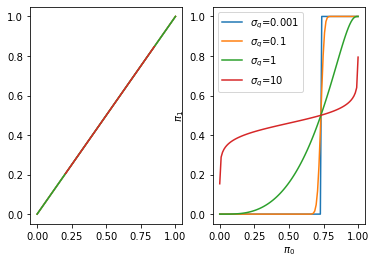

In [29]:
# \pi_0 = P(q < \sigma^{-1}(\eta) | i = 0)
# \pi_1 = P(q >= \sigma^{-1}(\eta) | i = 1)

from matplotlib import pyplot as plt
import numpy as np
import scipy.stats as st

def inverse_sigma(y):
    return -np.log((1. - y)/y)

def specificity(eta, mu_0, sigma_q):
    return st.norm.cdf(inverse_sigma(eta), loc=mu_0, scale=sigma_q)

def sensitivity(eta, mu_1, sigma_q):
    return 1 - st.norm.cdf(inverse_sigma(eta), loc=mu_1, scale=sigma_q)

mu_0 = 1
mu_1 = 10
sigma_q_s = [0.001, 0.1, 1, 10]

eta_choices = np.linspace(1e-4, 0.9999, 100)
fig, axs = plt.subplots(1, 2)
for sigma_q in sigma_q_s:
    specificities = specificity(eta_choices, mu_0, sigma_q)
    sensitivities = sensitivity(eta_choices, mu_0, sigma_q)
    axs[0].plot(1-specificities, sensitivities, label=f'$\sigma_q$={sigma_q}')
    axs[1].plot(eta_choices, specificities, label=f'$\sigma_q$={sigma_q}')
    
plt.ylabel('$\pi_1$')
plt.xlabel('$\pi_0$')
plt.legend()
plt.show()

In [27]:
specificities, sensitivities, eta_choices

(array([0.15362153, 0.288589  , 0.31289444, 0.32771047, 0.33851805,
        0.34709037, 0.35423224, 0.36037879, 0.36579242, 0.37064386,
        0.37505051, 0.37909664, 0.38284484, 0.38634286, 0.38962801,
        0.39273002, 0.39567294, 0.39847654, 0.40115728, 0.403729  ,
        0.40620347, 0.40859078, 0.41089967, 0.41313774, 0.41531167,
        0.41742736, 0.41949005, 0.42150443, 0.42347471, 0.42540469,
        0.42729783, 0.42915726, 0.43098588, 0.43278635, 0.43456111,
        0.43631245, 0.43804249, 0.43975323, 0.44144654, 0.4431242 ,
        0.44478788, 0.44643918, 0.44807965, 0.44971076, 0.45133394,
        0.45295057, 0.45456201, 0.45616958, 0.45777458, 0.45937831,
        0.46098206, 0.4625871 , 0.46419472, 0.46580624, 0.46742295,
        0.46904622, 0.4706774 , 0.47231792, 0.47396923, 0.47563285,
        0.47731035, 0.4790034 , 0.48071372, 0.48244315, 0.48419364,
        0.48596727, 0.48776625, 0.48959296, 0.49144997, 0.49334007,
        0.4952663 , 0.49723195, 0.49924068, 0.50

## Group testing with uncertainty

Before we start to formalize the problem set up, it can be healthy to ask ourselves what do we expect to happen when we start using a noisy testing procedure with pooled samples... Would we expect the expected number of tests to increase or decrease? Do we expect the amount of false positives/negatives to be larger or smaller than the individual testing strategy?

At first sight, it's hard to imagine how errors could help in any way. But it's also easy to show that a noisy testing procedure could actually reduce the expected number of tests, though at the expense of increasing the false negative rate. To see this, consider the extreme case of a test with zero specificity, which always rejects all groups. We will only perform $\frac{N}{g}$ tests, but we will have a terrible false negative rate (we won't identify any infection!). This very simple line of reasoning seems to suggest that errors can increase or decrease both the number of tests we end up performing as well as the performance of our estimates.

Let's setup the problem now. We will need to expand the individual testing notation from the previous section and define:

* $\bar{i}_k$: a Bernouilli random variable denoting whether *anyone* in the group is infected or not, which we can analytically define as $\bar{i}_k = \max_{j \in \mathcal{G}_k} i_j$.
* $\bar{q}_k$: a real-valued random variable corresponding to the measurement of a bio-marker for the pooled sample corresponding to group $k$. In general, $\bar{q}_k$ will be a function of $q_j, j \in \mathcal{G}_k$.
* $\bar{s}_k$: the group test statistic, which we will assume to take the form $\bar{s}_k = f(\bar{q}_k, \epsilon)$ where $f$ is deterministic and $\epsilon$ is iid noise.
* $\bar{t}_k$: the group test outcome, a Bernouilli random variable defined as follows:

$\bar{t}_k= \left\{\begin{array}{cc} 1 & \bar{s}_k\geq \bar{\eta} \\ 0 & \mbox{otherwise}\end{array}\right.$,

where $\bar{\eta}$ is now the *group decision threshold*. Same as earlier, we can now characterize the statistical performance of one group test by defining its:

* **Group-Specificity**, which we will denote by $\bar{\pi}_0$ and define as  $\bar{\pi}_0 = P\left(\bar{t} = 0 | \bar{i}_k = 0 \right)$,

* **Group-Sensitivity**, which we will denote by $\bar{\pi}_1$ and define as  $\bar{\pi}_1 = P\left(\bar{t} = 0 | \bar{i}_k = 1\right)$

The following diagram can serve as a quick reminder of the group testing setup and notation:

![Notation convention](simple_group_testing_setup.png)


### Impact of dilution on group-specificity and group-sensitivity 

The first question we may want to answer is how the specificity and sensitivity are impacted by the effect of pooling, under the above model. The main problem we can anticipate is that of "dilution", that is, if only one of the individuals in the group is infected, then its biomarker measurement will be diluted within the measurements of all the other healthy members of the group.

In order to gain understanding without resorting to computational
tools, we will make a few additional simplifying assumptions:

1. We will assume that, conditional on the infection indicator, the biomarker measurements follow a Normal distribution $q_j | i_j \sim  \mathcal{N}\left(\mu_{i_j}, \sigma_q\right)$ parameterized by $\mu_0, \mu_1$ and $\sigma_q$.
2. We will also assume that the pooled biomarker measurement is equal to the average of biomarker measurements in the pool, that is $\bar{q}_k = \frac{1}{g}\sum_{j \in \mathcal{G}_k} q_j$
3. We will also assume that both the group and individual testing statistics, are defined by the following relation  $s = f\left(q\right)$ where $f$ is a monotonic function of its argument. 

Note that the last 2 assumptions seems reasonable: On one hand, if we are measuring concentrations of a given biomarker in a sample, when mixing the samples we would expect the resulting concentration to be the average of each member in the pool. On the other, a well-behaved test statistic should evolve montonically with the concentration of interest.

Under these additional assumptions we can write the group-specificity as:

$\bar{\pi}_0 = P\left(\bar{t} = 0 | \bar{i}_k = 0 \right) = P\left(\bar{s}_k < \eta | \bar{i}_k = 0 \right) = P\left(f(\bar{q}_k) < \eta | \bar{i}_k = 0 \right) = P\left(\bar{q}_k < f^{-1}\left(\eta\right) | \bar{i}_k = 0 \right)$

Since the individuals in the group have been chosen uniformly at random, it is fair to expect the quantities 
$q_j, j \in \mathcal{G}_k$ to be independent of each other, which allows us to conclude that:

$\bar{q}_k | \bar{i}_k = 0 \sim \mathcal{N}\left(\mu_{0}, \sigma_q\right)$,

where we have used the property that the sum of two normally distributed random variables is normally distributed with mean and variance equal to the sum of means and variances of each summand, respecively. As a consequence, we have:

$\bar{\pi}_0 =  P\left(\bar{q}_k  | \bar{i}_k = 0 \right) = P\left( q_j < f^{-1}\left(\eta\right) | i_j = 0 \right) = \pi_0$

So under this simplified model, **the effect of sample dilution does not degrade the test group-specificity, relative to the specificity of tests with non-pooled samples**.

On the other hand, we have that for the group-sensitivity:

$\bar{\pi}_1 = P\left(\bar{t} = 1 | \bar{i}_k = 1 \right) = P\left(\bar{s}_k \geq \eta | \bar{i}_k = 1 \right) =  P\left(\bar{q}_k \geq f^{-1}\left(\eta\right) | \bar{i}_k = 1 \right)$

This expression is trickier to evaluate because there are several combinations of $\left\{i_j, j \in \mathcal{G}_k\right\}$ that correspond to $\bar{i}_k = 1$. The good news is that, given the individual-to-individual independence of $q_j$, and letting $m_k$ denote the number of
infected individuals in group $\mathcal{G}_k$, we can easily characterize $\bar{q}_k$ as:

$\bar{q}_k | m_k \sim \mathcal{N}\left(\frac{1}{g}\left(\mu_{0} + m_k \mu_{1}\right), \sigma_q\right)$.

On the other hand, we also know that $m_k$ is a Binomial random variable:

$P\left(m_k = m\right) = {g \choose m} p^m\left(1 - p\right)^{g-m}$ 

and hence:

$\bar{\pi}_1 = \sum_{m=1}^g P\left(\bar{q}_k \geq f^{-1}\left(\eta\right) | \bar{i}_k = 1, m_k=m\right)P\left(m_k=m\right)$

This quantity is to be compared to $\pi_1$ to understand the effect of the dilution. To do so, 
observe that:

$\bar{q}_k | m_k=g \sim \mathcal{N}\left(\mu_{1}, \sigma_q\right)$

which means that the term:

$P\left(\bar{q}_k \geq f^{-1}\left(\eta\right) | \bar{i}_k = 1, m_k=g\right) = \pi_1$

This implies that **$\bar{\pi}_1 \leq \pi_1$, which confirms our initial intuition that dilution should hurt sensitity**. In what follows, we will characterize computationally the 
degradation of $\bar{\pi}_1$ as a function of $p$ and $g$, under the simplified model we have used throughout this section:

### Impact of noise on the number of tests performed

We have reasoned earlier that noisy tests can both reduce or increase the number of tests we need to perform under Dorfman's two-stage procedure. Let's attempt now to characterize that quantity, as well as the savings relative to an individual testing strategy, when the tests have known sentitivity and specificity, denoted by $\bar{\pi}_1$ and $\bar{\pi}_0$.

We saw in the [first post](https://atibaup.github.io/group-testing/) that under an inter-group independence assumption, the expected number of tests performed is given by:

$E\left(T'\right) = E\left(\sum_{n=1}^{N/g} I_{\bar{t}_n=1}\left(g + 1\right) + I_{\bar{t}_n=0} \right) = \frac{n}{g}\left(\left(1- P_0\right)\left(g + 1\right) + P_0\right)$

where we use $T'$ to indicate the number of tests necessary in the presence of test errors,
to differentiate it from the number of tests $T$ in the errorless setting, and where $P_0$ denotes the probability of the group-test turning negative:

$P_0 = E\left(I_{\bar{t}_n=0}\right) = P\left(\bar{t}_n=0\right)$,

which under the presence of noise, is now a function of
$\bar{\pi}_1$ and $\bar{\pi}_0$:

$P_0 = P\left(\bar{t}_n=0 | \bar{i}_n = 0\right)P\left(\bar{i}_n = 0\right) + P\left(\bar{t}_n=0 | \bar{i}_n = 1\right)P\left(\bar{i}_n = 1\right) = \bar{\pi}_0 P^i_0 + \left(1 - \bar{\pi}_1\right)\left(1 - P^i_0\right)$

where we have let $P^i_0=P\left(\bar{i}_n = 0\right) = \left(1 - p\right)^g$ (provided again we have intra-group dependency between the individuals). 

We can also define the savings relative to the individual testing strategy and calculate its expectation:

$E\left(\gamma'\right) = 1 - \frac{g + 1}{g}\left(1 - P_0\right) - \frac{1}{g}P_0$

Notice that the approximation we calculated for $E\left(\gamma'\right)$ in the [first post](https://atibaup.github.io/group-testing/) is still valid. Now as $p \to 0$, we have that $P_0 \to \bar{\pi}_0$ instead of $0$ and thus 

$E\left(\gamma'\right) \approx \frac{g - 1}{g}$

Let's explore the dependency of $E\left(\gamma'\right)$ on $p$, $g$ and $\bar{\pi}_1$ and $\bar{\pi}_0$:

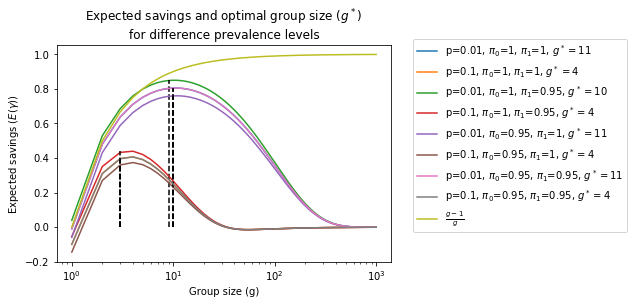

In [3]:
from matplotlib import pyplot as plt
import numpy as np

def approximation(group_size):
    return (group_size-1)/group_size

def expected_savings(p, group_size, pi_0, pi_1):
    p_i_0 = np.power(1 - p, group_size)
    p_z = pi_0*p_i_0 + (1-pi_1)*p_i_0
    p_nz = 1 - p_z
    savings = 1 - (group_size+1)/group_size * p_nz - 1/group_size*p_z
    return savings

p_choices = [1e-2, 1e-1]
pi_0_choices = [1.0, 0.95]
pi_1_choices = [1.0, 0.95]
g_values = np.arange(1, 1000, step=1)

for pi_0 in pi_0_choices:
    for pi_1 in pi_1_choices:
        for p in p_choices:
            savings = np.array([expected_savings(p, g, pi_0, pi_1) for g in g_values])
            opt_g = np.argmax(savings)
            plt.semilogx(
                g_values, savings, 
                label=f'p={p:.2g}, $\pi_0$={pi_0:.2g}, $\pi_1$={pi_1:.2g}, $g^*={g_values[opt_g]}$')
            plt.semilogx([opt_g, opt_g], [0, savings[opt_g]], '--k')
    
plt.semilogx(g_values, [approximation(g) for g in g_values], label='$\\frac{g -1}{g}$')

plt.xlabel('Group size (g)')
plt.ylabel('Expected savings ($E(\gamma)$)')
plt.legend(bbox_to_anchor=(1.05, 1.05))
plt.title('Expected savings and optimal group size ($g^*$)\nfor difference prevalence levels')
plt.show()

### Impact of noise on the number of false positives
